In [1]:
library(MASS)
library(ggplot2)
library(cowplot)
library(hydroPSO)
library(doParallel)
library(data.table)
library(plotly)
library(htmlwidgets)
library(RColorBrewer)

options(repr.plot.width=17, repr.plot.height=8)

### Kernel
k <- function(x,x2) {
  5*exp(-.1*norm(x-x2,'2'))
}

# Objective function noise
f <- function(x) sin(.2*x[[1]]*x[[2]]) + sin(.5 * x[[1]])
# f <- function(x) (x[[1]]^2 + x[[2]] - 11)^2 + (x[[1]] + x[[2]]^2 -7)^2
f.noise <- 0

# GP prior mean
prior.mu <- function(x) 0

# Plot values
x.limits <- c(0, 10)
y.limits <- c(-3, 3)

# Optimization values
n.iterations <- 50
batch.size <- 1
n.cores <- 7
n.pso.particles <- 10
use.optimization <- FALSE

(C) 2011-2020 M. Zambrano-Bigiarini and R. Rojas (GPL >=2 license)
Type 'citation('hydroPSO')' to see how to cite this package

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:MASS’:

    select


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




In [2]:
# Function definitions

calculate.regression.model <- function(X, y) {
  if (nrow(X) == 0) {
    K <- numeric(0)
    Ki <- K
  } else {
    K <- outer(1:nrow(X), 1:nrow(X), Vectorize(function(i,j) {
      k(X[i,], X[j,])
    }))
    if (nrow(X) == 1) {
      Ki <- 1/(K + f.noise)
    } else {
      Ki <- ginv(K + f.noise*diag(K))
    }
  }
  
  fs <- function(Xs) {
    if (nrow(X) == 0)
      return(prior.mu(Xs))
    
    # Ks <- outer(Xs, X, k)
    Ks <- outer(1:nrow(Xs), 1:nrow(X), Vectorize(function(i,j) {
      k(Xs[i,], X[j,])
    }))
    return(prior.mu(Xs) + Ks %*% Ki %*% (y - prior.mu(Xs)))
  }

    
  sigma <- function(Xs) {
    Kss <- outer(1:nrow(Xs), 1:nrow(Xs), Vectorize(function(i,j) {
      k(Xs[i,], Xs[j,])
      }))
    # Kss <- apply(Xs, 1, function(r) k(r,r))
    
    if (nrow(X) == 0)
      return(Kss)
    
    # Ks <- outer(Xs, X, k)
    Ks <- outer(1:nrow(Xs), 1:nrow(X), Vectorize(function(i,j) {
      k(Xs[i,], X[j,])
    }))
    S <- Kss - Ks %*% Ki %*% t(Ks)
    # if (Xs %in% observed.x && f.noise == 0)
    #   S <- matrix(0) # Due to numerical instability values already observed haved a non-zero sigma, forcing 0 here
    S <- apply(S, 1:2, function(x) max(x,0)) # Numerical instability, (small) negative values should be 0
    return(S)
  }
  
  if (nrow(X) == 0) {
    best.x <- c(0,0)
    best.y <- prior.mu(c(0,0))
  } else {
    best.x <- X[which.max(y),]
    best.y <- max(y)
  }
  
  return(list(mean=fs, cov=sigma, best.x=best.x, best.y=best.y))
}

if (use.optimization) {
  choose.next.evaluation.points <- function(x, y.acq, observed.x, gp.model) {
    optim.func <- function(x) -acq.func(gp.model, x)
    # sink('/dev/null')
    best <- tryCatch(suppressMessages(
      hydroPSO(fn=optim.func,
               lower=c(0,0),
               upper=c(10,10),
               control=list(
                 npart=n.pso.particles
                 )))
      # ,finally=sink()
      )
    names(best$par) <- c('x1', 'x2')
    return(best$par)
  }
} else {
  choose.next.evaluation.points <- function(x, y.acq, observed.x, gp.model) {
    y2 <- y.acq[!(x$x1 %in% observed.x$x1 & x$x2 %in% observed.x$x2)]
    x2 <- x[!(x$x1 %in% observed.x$x1 & x$x2 %in% observed.x$x2),]
    order.index <- order(y2, decreasing = T)
    y2 <- y2[order.index]
    x2 <- x2[order.index,]
    n.best <- sum(y2==y2[1])
    if (n.best == 1) {
      best.x <- 1
    } else {best.x <- sample(1:n.best, 1)}
    permutation <- c(best.x,sample(2:nrow(x2)))
    x2 <- x2[permutation,]
    y2 <- y2[permutation]
    next.evaluation.points <- unlist(x2[1:batch.size,])
    return(next.evaluation.points)
  }
}

acq.func <- function(gp.model, x) {
  return(acq.func.ei(gp.model, x))
}

acq.func.ei <- function(gp.model, x) {
  x2 <- data.frame(x)
  mu <- gp.model$mean(x2)
  tryCatch(
    sigma <- sqrt(gp.model$cov(x2)[1,1]),
  warning=function(e) {
    browser()})
  best.y <- gp.model$best.y
  if (sigma > 0) {
    return((mu-best.y)*pnorm((mu-best.y)/sigma) + sigma*dnorm((mu-best.y)/sigma))
  } else { # Observed value, no uncertainty
    return(max(mu-best.y,0))
  }
}

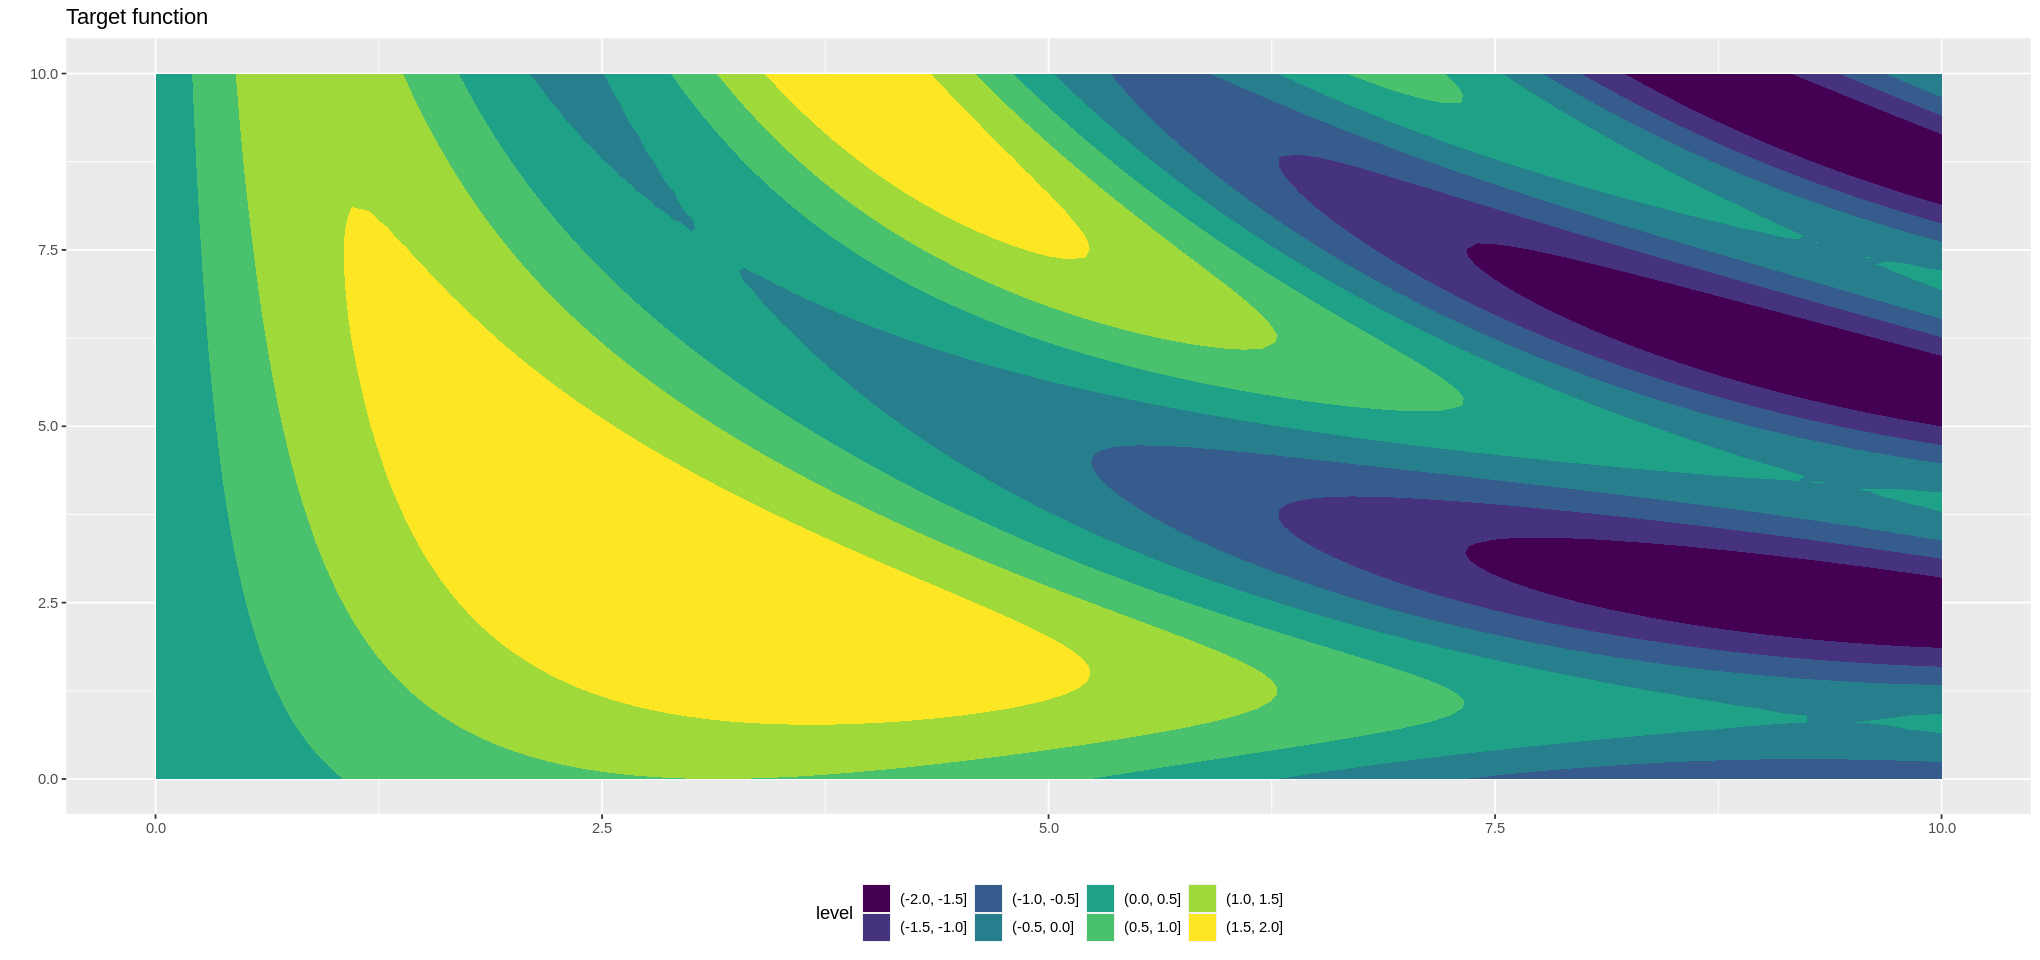

In [3]:
# Build target function plot

x1.plt <- seq(0, 10, .1)
x2.plt <- seq(0, 10, .1)
df.f <- expand.grid(x1.plt, x2.plt)
names(df.f) <- c('x', 'y')
x.plt <- df.f
df.f$z <- apply(df.f, 1, f)
names(x.plt) <- c('x1', 'x2')

color.breaks <- seq(-2,2,.4)

plt.f <- ggplot(df.f, aes(x=x, y=y, z=z)) + 
  geom_contour_filled(
    # breaks=color.breaks
    ) +
  theme(legend.position = "bottom") +
  xlab('') +
  ylab('') +
  ggtitle('Target function')
plt.f

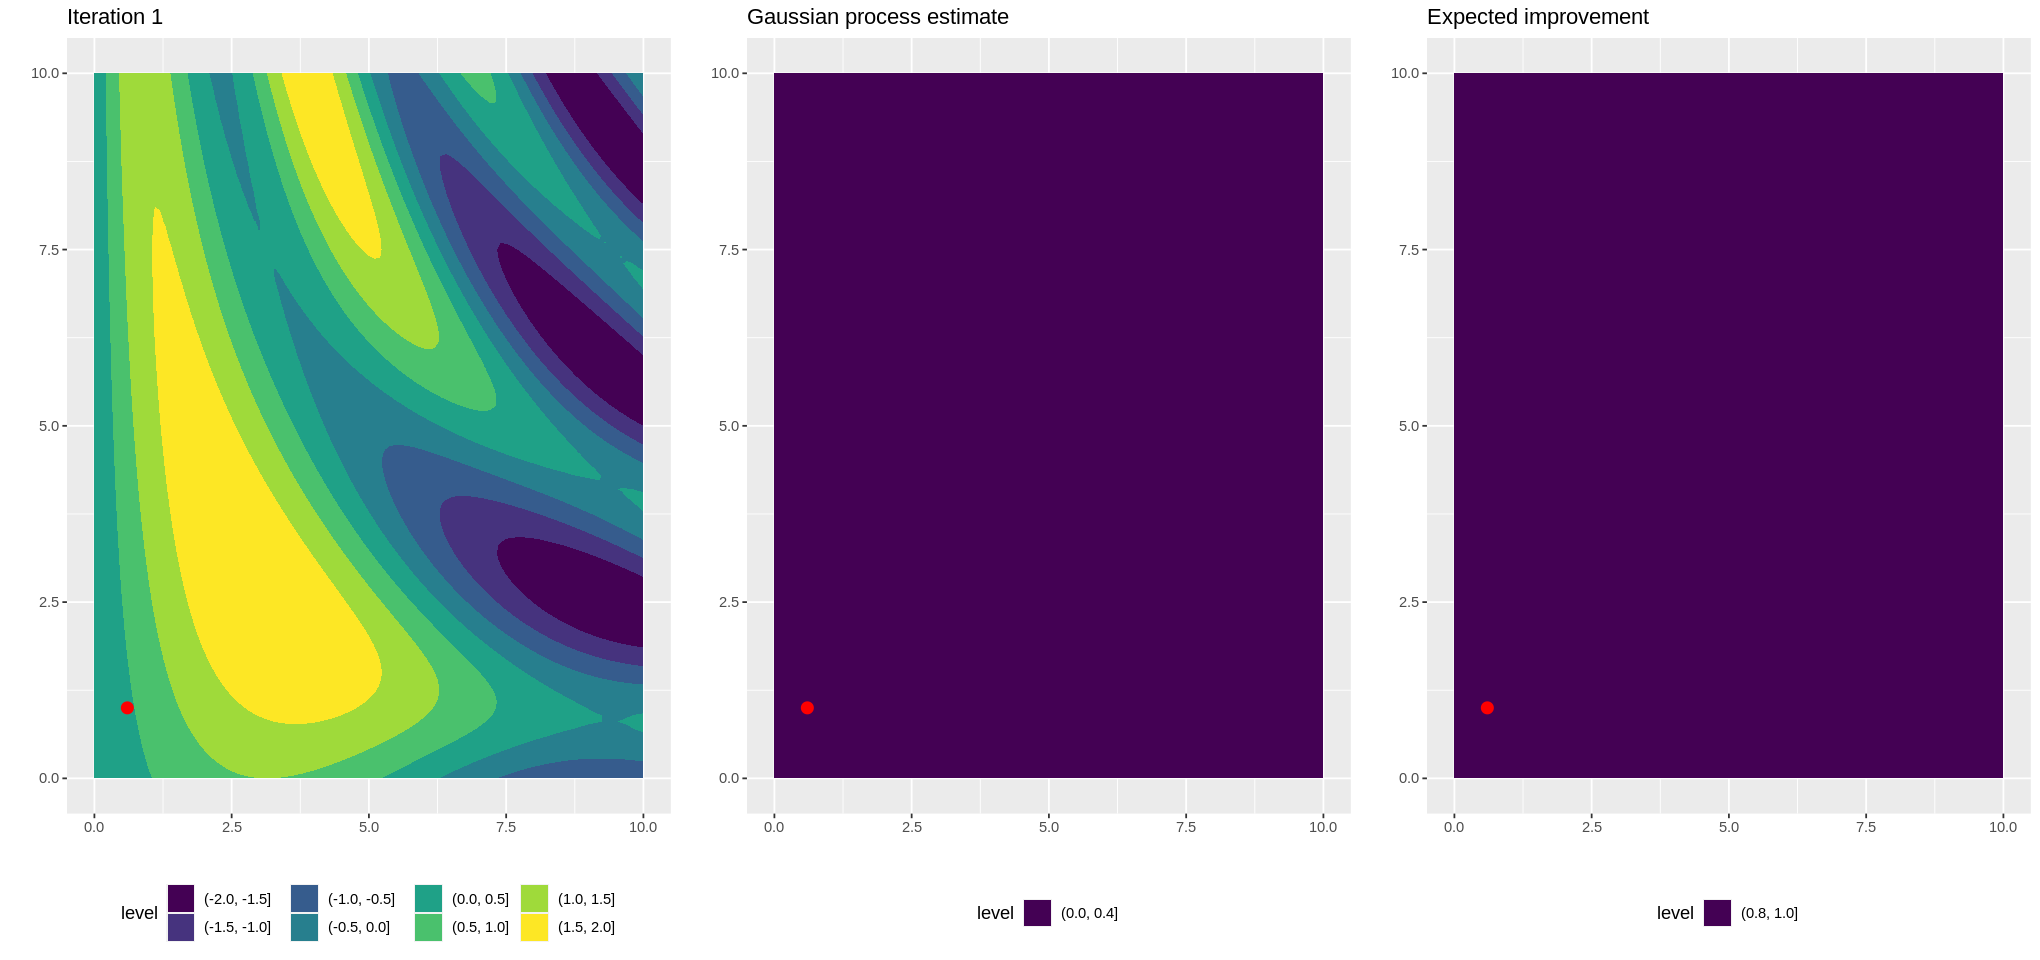

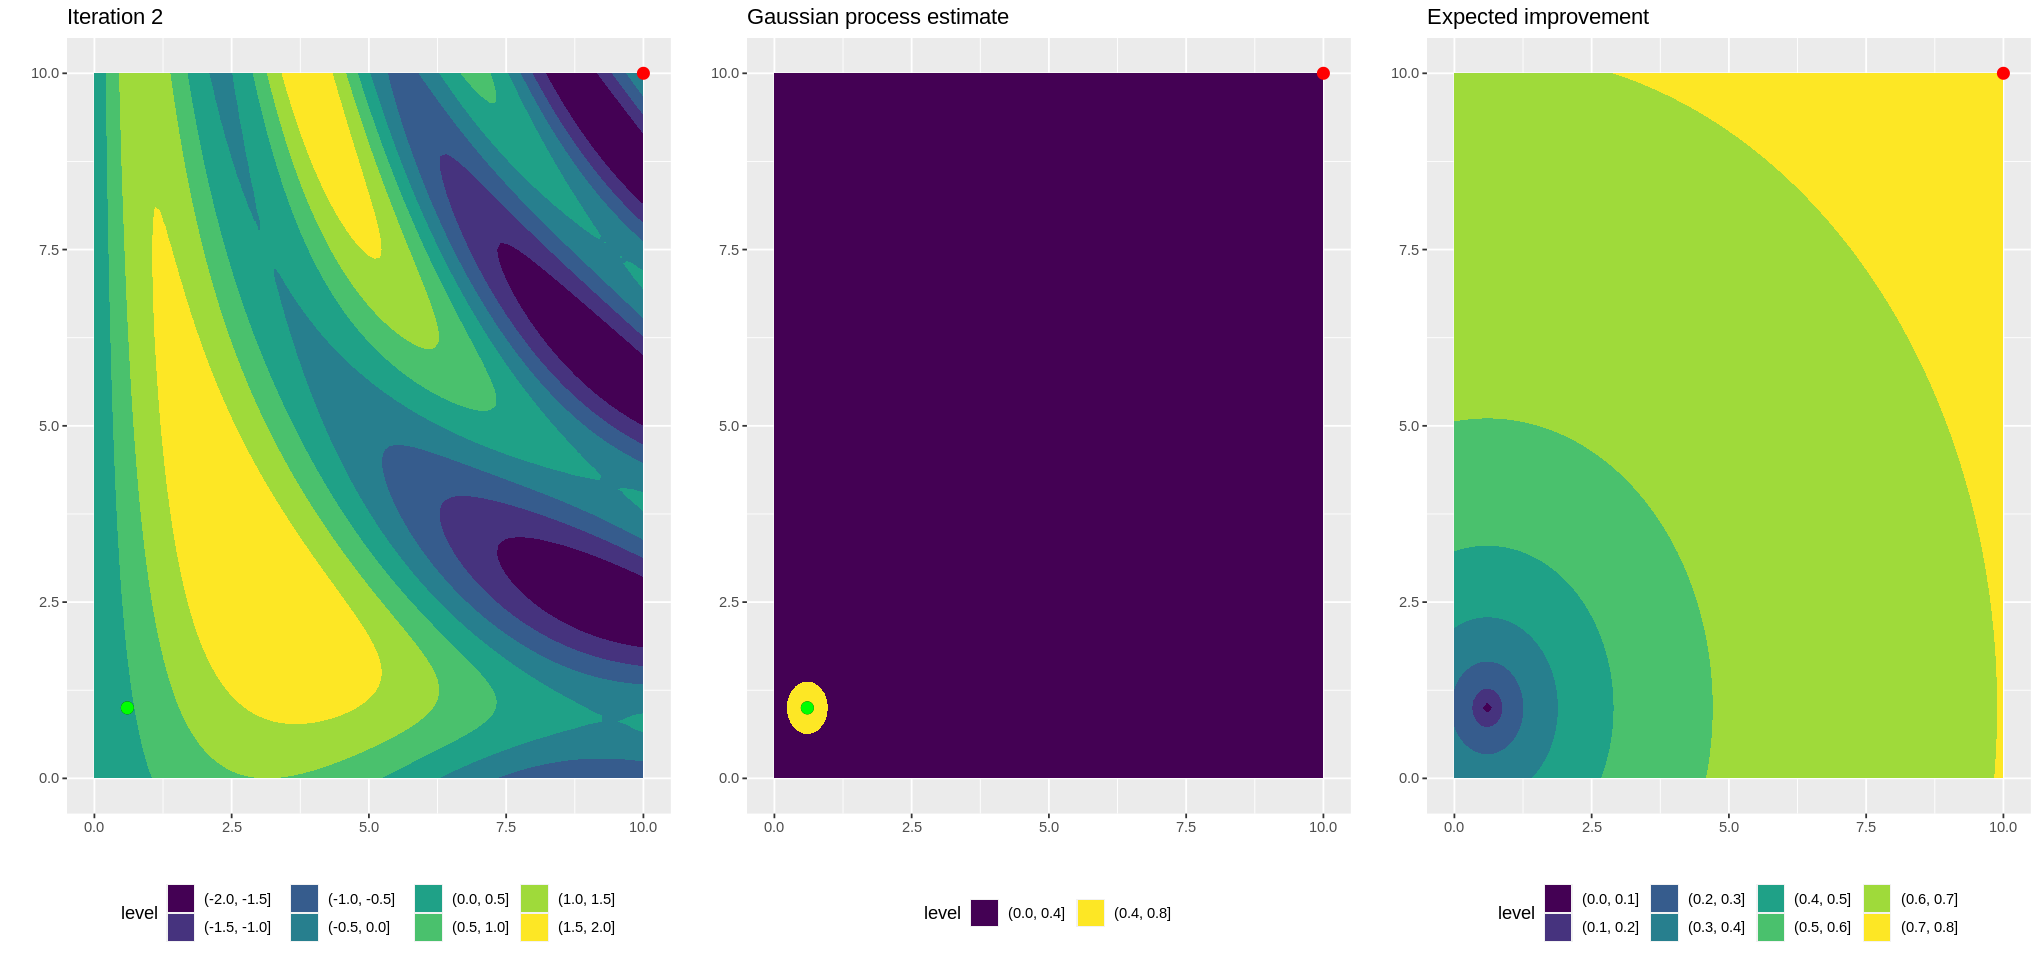

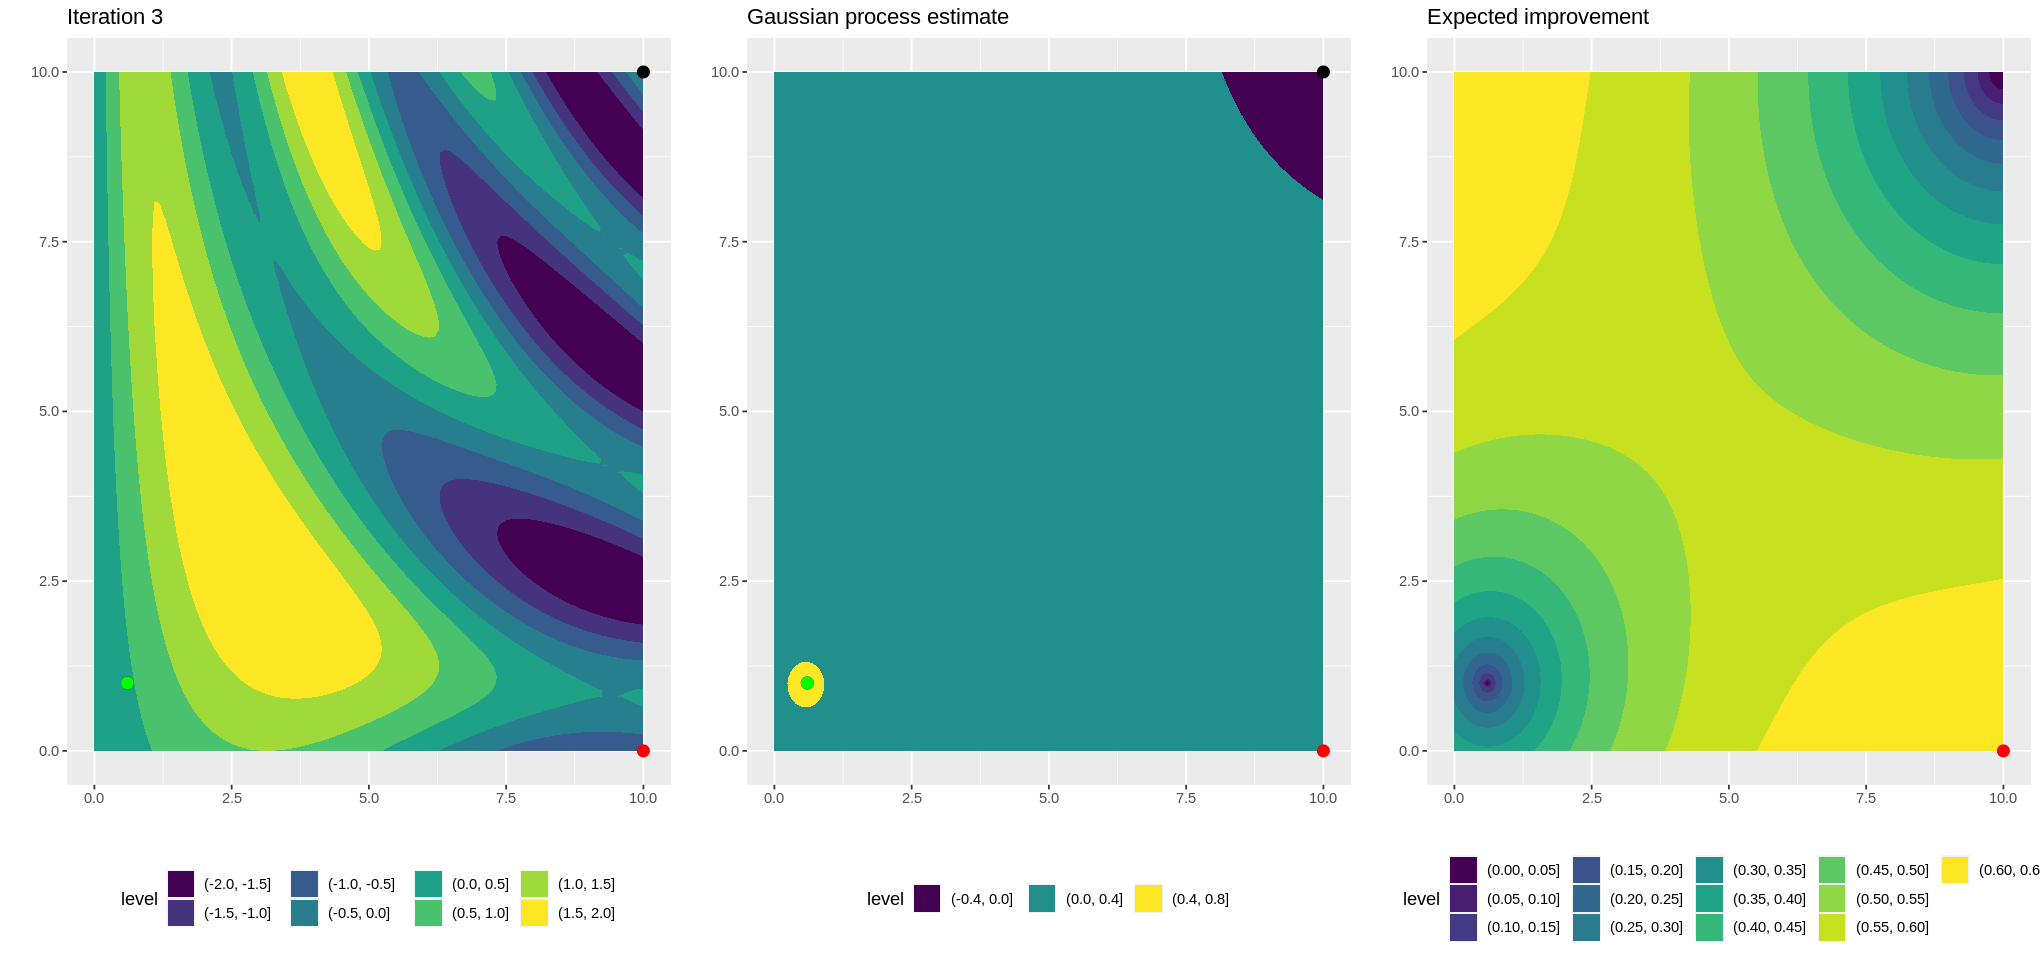

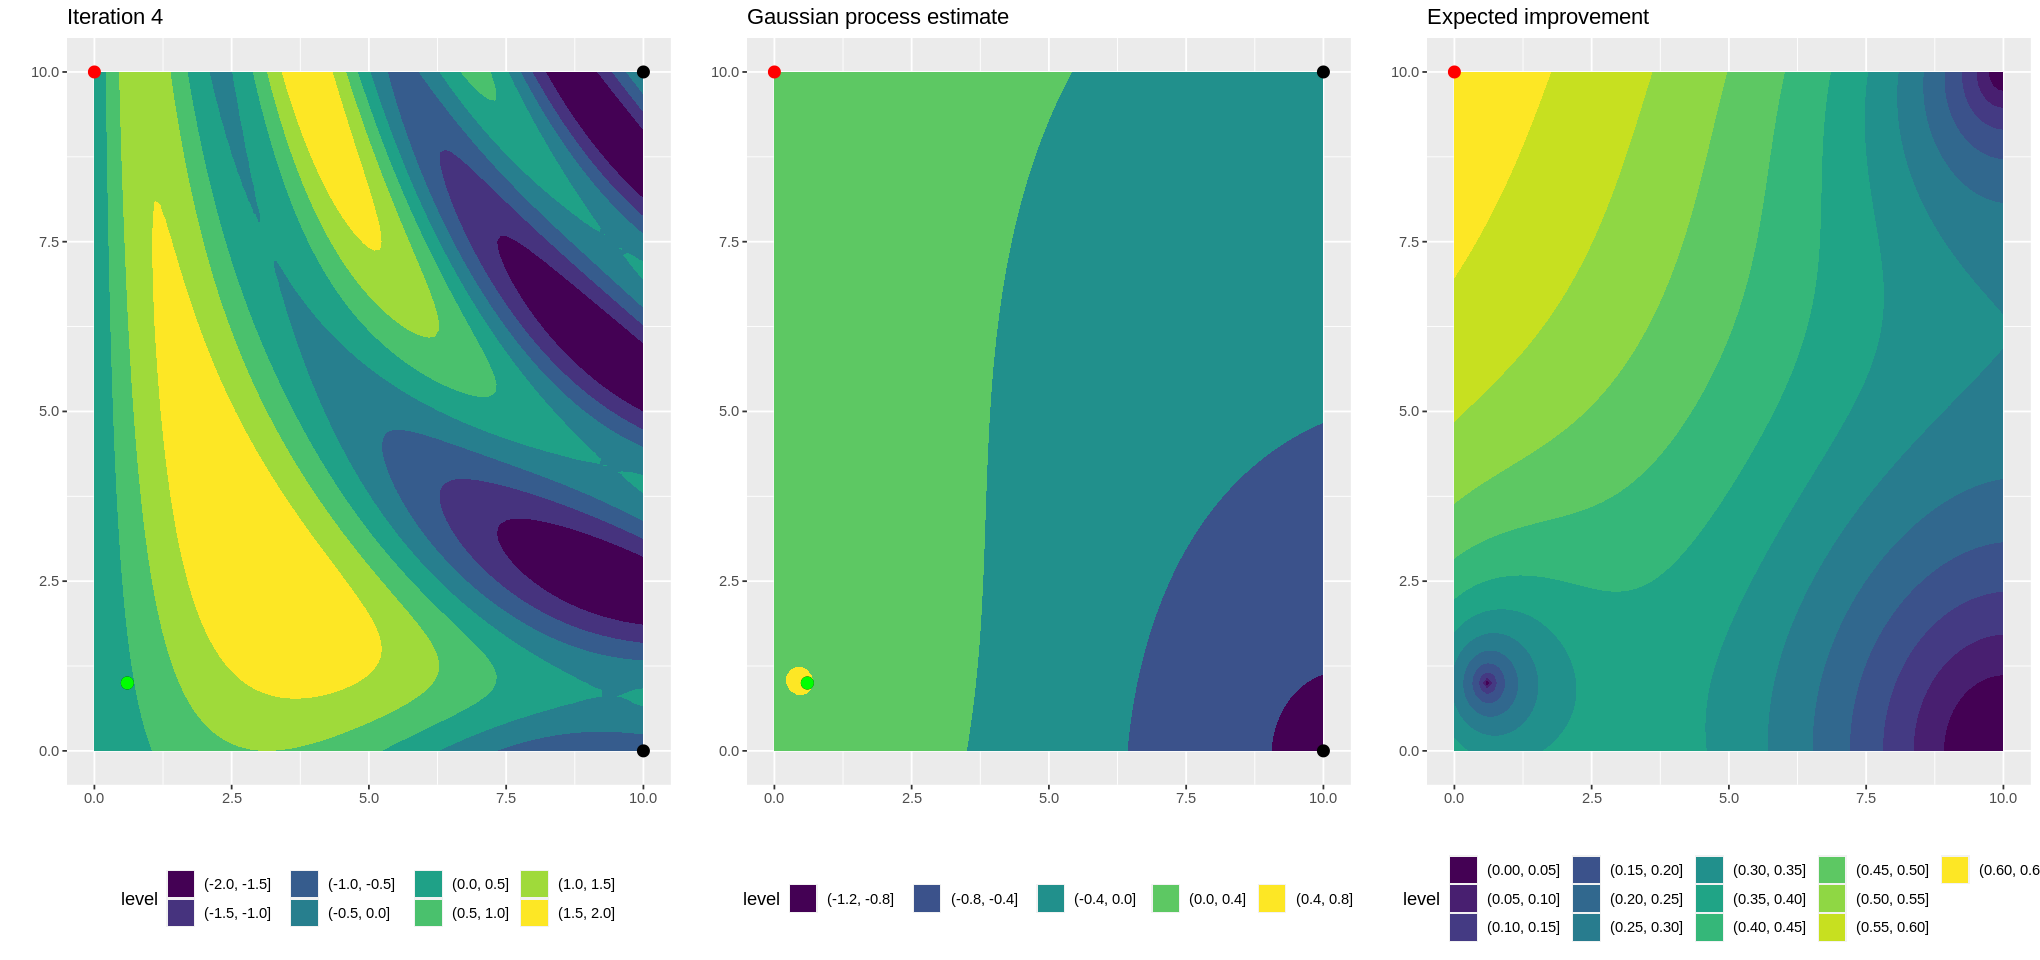

In [4]:
# Start optimization

observed.x <- data.frame(matrix(ncol=2,nrow=0))
colnames(observed.x) <- c('x1', 'x2')
observed.y <- numeric(0)

set.seed(1)

cl <- makeCluster(n.cores)
clusterExport(cl, c('prior.mu', 'k'))
registerDoParallel(cl)

for(n in seq(n.iterations)) {
  gp.model <- calculate.regression.model(observed.x, observed.y)
  
  xx <- x.plt
  yy.acq <- foreach(x=iter(xx, by='row'), .combine = 'c') %dopar% {
    acq.func(gp.model, x)
  }
  
  next.evaluation.points <- choose.next.evaluation.points(xx, yy.acq, observed.x, gp.model)
  
  yy <- foreach(x=iter(xx, by='row'), .combine='c') %dopar% {
    gp.model$mean(data.frame(x))
  }
  ss <- foreach(x=iter(xx, by='row'), .combine='c') %dopar% {
    sqrt(max(gp.model$cov(data.frame(x))[1,1], 0))
  }
  
  df <- data.frame(x=xx$x1, y=xx$x2, z=yy)
  points.df <- data.frame(x=observed.x$x1, y=observed.x$x2, z=observed.y)
  next.points.df <- data.frame(x=next.evaluation.points[[1]], y=next.evaluation.points[[2]], z=f(next.evaluation.points))
  if (nrow(observed.x) > 0)
    best.point.df <- data.frame(x=gp.model$best.x[[1]], y=gp.model$best.x[[2]], z=f(gp.model$best.x))
  else
    best.point.df <- data.frame(x=numeric(0), y=numeric(0), z=numeric(0))
  
  plt.f2 <- plt.f +
    geom_point(data=points.df, color='black', size=3) +
    geom_point(data=next.points.df, color='red', size=3) +
    geom_point(data=best.point.df, color='green', size=3) +
    ggtitle(paste0('Iteration ', n))
  
  plt <- ggplot(df, aes(x=x, y=y, z=z)) +
    geom_contour_filled(
      breaks=color.breaks
      ) +
    geom_point(data=points.df, color='black', size=3) +
    geom_point(data=next.points.df, color='red', size=3) +
    geom_point(data=best.point.df, color='green', size=3) +
    theme(legend.position = "bottom") +
    xlab('') +
    ylab('') +
    ggtitle('Gaussian process estimate')
  
  observed.x <- rbind(observed.x, data.frame(t(next.evaluation.points)))
  observed.y <- c(observed.y, f(next.evaluation.points))
  
  df.acq <- data.frame(x=xx$x1, y=xx$x2, z=yy.acq)
  acq.plt <- ggplot(df.acq, aes(x=x, y=y, z=z)) +
    geom_contour_filled() +
    geom_point(data=next.points.df, color='red', size=3) +
    theme(legend.position = "bottom") +
    xlab('') +
    ylab('') +
    ggtitle('Expected improvement')
  
  plt2 <- plot_grid(plt.f2, plt, acq.plt, ncol=3, align='h')
  
  print(plt2)
}

stopCluster(cl)